<a href="https://colab.research.google.com/github/dguhanus/Hyperspectral_Classification/blob/main/Hyperspectral_Image_Analysis%E2%80%8A_%E2%80%8AClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color = 'tomato'>Hyperspectral Image Analysis - Classification</font>

## Import Libraries

In [1]:
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.axes_style('whitegrid');
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
cd /content/drive/MyDrive/Python_Image_Inverse_Problem/HSI_Classify/

/content/drive/MyDrive/Python_Image_Inverse_Problem/HSI_Classify


## Download HSI Data

In [ ]:
#!wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

In [8]:
!ls

 Hyperspectral_Image_Analysis _ Classification.ipynb
 Indian_pines_corrected.mat
 Indian_pines_gt.mat
'Land_Cover_Classification_of_Hyperspectral_Imagery_using_Deep_Neural Networks(DNN).ipynb'


## Read the Data

In [9]:
from scipy.io import loadmat

def read_HSI():
  X = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
  y = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y

X, y = read_HSI()

X shape: (145, 145, 200)
y shape: (145, 145)


### Visualize Bands

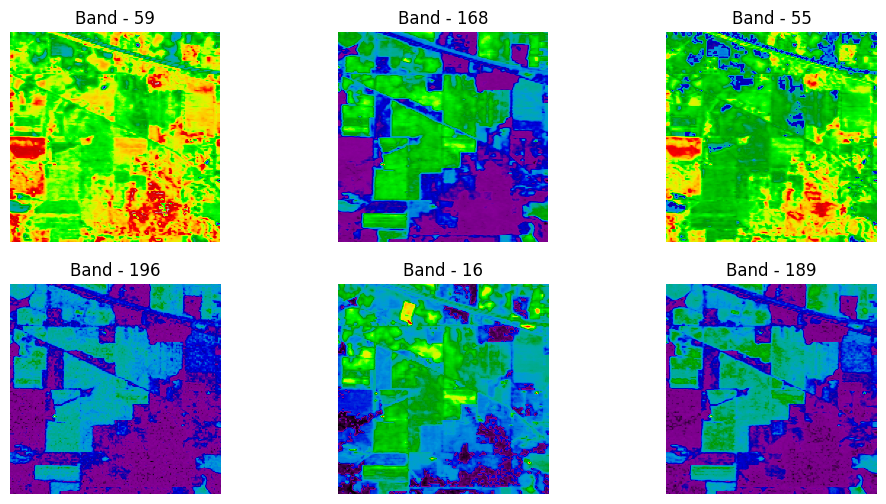

In [10]:
fig = plt.figure(figsize = (12, 6))

for i in range(1, 1+6):
    fig.add_subplot(2,3, i)
    q = np.random.randint(X.shape[2])
    plt.imshow(X[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')
plt.savefig('IP_Bands.png')

### Visualize the Ground Truth

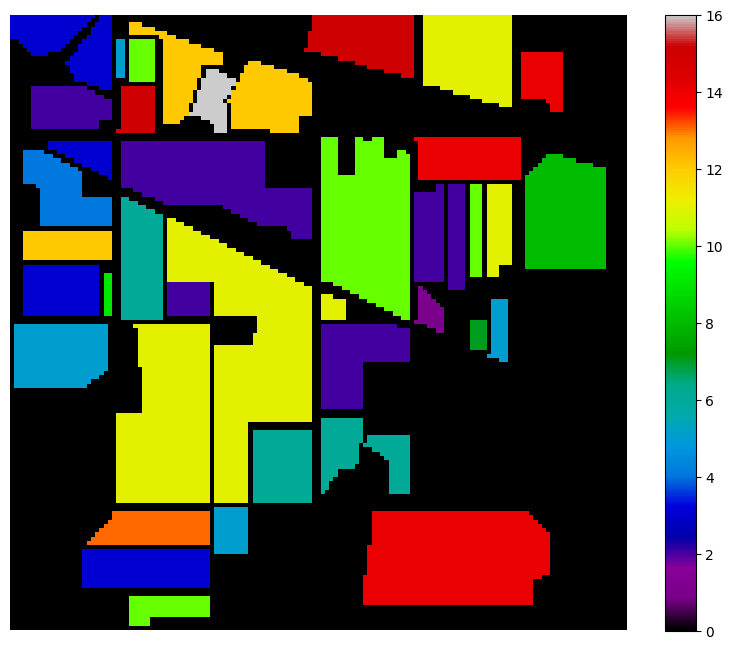

In [11]:
plt.figure(figsize=(10, 8))
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_GT.png')
plt.show()

## Convert the dataset into csv

In [12]:
import pandas as pd
import numpy as np

def extract_pixels(X, y):
  q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
  df.to_csv('Dataset.csv')
  return df

df = extract_pixels(X, y)


In [13]:
df.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band192,band193,band194,band195,band196,band197,band198,band199,band200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,...,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,...,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,...,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,...,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21025 entries, 0 to 21024
Columns: 201 entries, band1 to class
dtypes: uint16(200), uint8(1)
memory usage: 8.0 MB


In [15]:
df.iloc[:, :-1].describe()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,...,band191,band192,band193,band194,band195,band196,band197,band198,band199,band200
count,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,...,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000,21025.000000
mean,2957.363472,4091.321237,4277.502259,4169.956671,4516.678668,4790.595149,4848.317574,4714.732509,4668.904828,4439.065541,...,1079.310773,1061.927848,1060.210273,1063.276813,1050.048514,1040.201141,1043.370321,1030.194816,1015.571463,1008.513579
std,354.918708,230.390005,257.827640,280.761254,346.035984,414.382138,469.247667,491.728349,533.232855,539.908195,...,49.943791,38.843805,38.712195,41.920969,34.242725,26.452672,29.794418,20.865106,11.386402,7.050921
min,2560.000000,2709.000000,3649.000000,2810.000000,3840.000000,4056.000000,4004.000000,3865.000000,3775.000000,2792.000000,...,998.000000,998.000000,999.000000,999.000000,993.000000,990.000000,992.000000,989.000000,986.000000,981.000000
25%,2602.000000,3889.000000,4066.000000,3954.000000,4214.000000,4425.000000,4421.000000,4263.000000,4173.000000,3940.000000,...,1031.000000,1026.000000,1024.000000,1024.000000,1019.000000,1016.000000,1016.000000,1012.000000,1006.000000,1004.000000
50%,2780.000000,4106.000000,4237.000000,4126.000000,4478.000000,4754.000000,4808.000000,4666.000000,4632.000000,4404.000000,...,1068.000000,1053.000000,1052.000000,1054.000000,1043.000000,1033.000000,1035.000000,1026.000000,1014.000000,1009.000000
75%,3179.000000,4247.000000,4479.000000,4350.000000,4772.000000,5093.000000,5198.000000,5100.000000,5084.000000,4860.000000,...,1129.000000,1099.000000,1098.000000,1104.000000,1083.000000,1066.000000,1072.000000,1050.000000,1024.000000,1014.000000
max,4536.000000,5744.000000,6361.000000,6362.000000,7153.000000,7980.000000,8284.000000,8128.000000,8194.000000,7928.000000,...,1364.000000,1287.000000,1289.000000,1315.000000,1258.000000,1201.000000,1245.000000,1167.000000,1076.000000,1036.000000


## Principal Component Analysis(PCA)


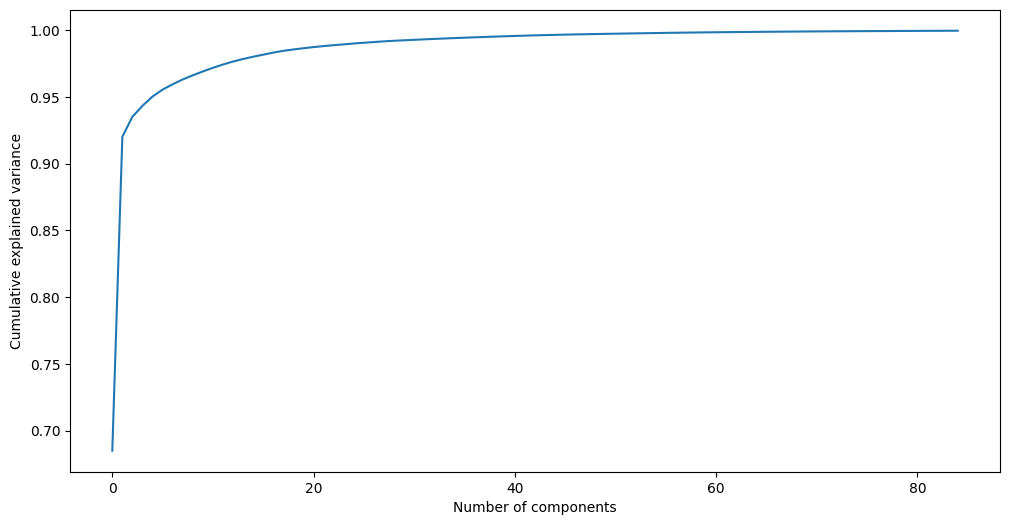

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 85)

principalComponents = pca.fit_transform(df.iloc[:, :-1].values)

ev=pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


plt.show()


Select 40 as the no.of components for PCA

In [17]:
pca = PCA(n_components = 40)
dt = pca.fit_transform(df.iloc[:, :-1].values)
q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = y.ravel())], axis = 1)
q.columns = [f'PC-{i}' for i in range(1,41)]+['class']

In [18]:
q.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,...,PC-32,PC-33,PC-34,PC-35,PC-36,PC-37,PC-38,PC-39,PC-40,class
0,5014.905985,1456.863260,72.697049,71.204929,-435.686983,-68.840312,134.809780,-304.372399,256.433018,-66.630882,...,20.052159,-3.193073,21.811186,-21.231676,-31.737633,23.072447,1.397667,62.002819,8.017912,3
1,5601.383743,-2023.450087,350.134661,-528.465046,148.088300,-288.359043,202.956764,240.848091,-474.857643,93.494029,...,100.939231,-81.781282,-50.668211,26.280316,14.068137,-24.791608,3.978157,12.888103,44.315777,3
2,5796.135442,-3090.394852,490.539930,-760.214335,259.933305,-131.611203,172.927146,205.911305,572.492040,-191.621518,...,35.446665,-38.902431,-14.940624,15.812346,35.779647,-24.062022,19.679235,-38.354736,94.198818,3
3,5586.204575,-2369.376085,356.274719,-502.687150,146.554956,-306.679325,251.070963,234.966534,-314.023234,54.962480,...,129.164601,-66.646963,34.582526,18.151940,65.493231,-12.769152,51.346048,0.089438,61.860712,3
4,5020.990792,339.603390,-23.007525,-92.556770,-368.495440,-438.266695,502.715453,-345.536620,-188.352886,-67.506095,...,-83.544989,72.733176,183.341885,-8.092836,-16.800623,-11.891642,1.287992,63.504613,12.589799,3


### Display the bands after PCA

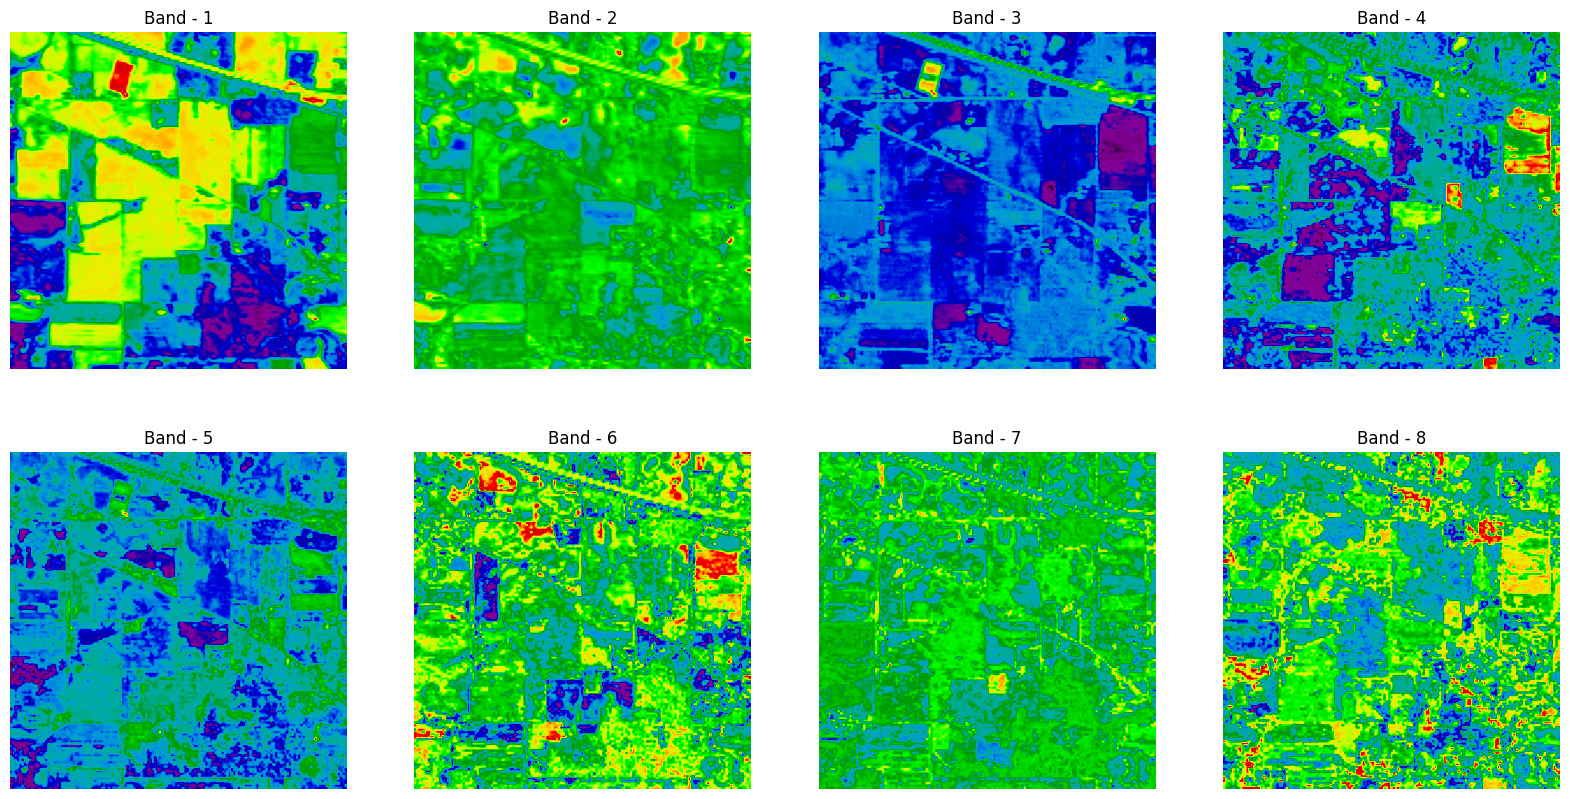

In [19]:
fig = plt.figure(figsize = (20, 10))

for i in range(1, 1+8):
    fig.add_subplot(2,4, i)
    plt.imshow(q.loc[:, f'PC-{i}'].values.reshape(145, 145), cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {i}')

plt.savefig('IP_PCA_Bands.png')

In [20]:
# saving to .csv
q.to_csv('IP_40_PCA.csv', index=False)

## Support Vector Machine(SVM)


In [21]:
x = q[q['class'] != 0]

X = x.iloc[:, :-1].values

y = x.loc[:, 'class'].values

names = ['Alfalfa',	'Corn-notill', 'Corn-mintill',	'Corn',		'Grass-pasture','Grass-trees',
'Grass-pasture-mowed','Hay-windrowed','Oats','Soybean-notill','Soybean-mintill',
'Soybean-clean', 'Wheat',	'Woods',	'Buildings Grass Trees Drives',	'Stone Steel Towers']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11, stratify=y)

svm =  SVC(C = 100, kernel = 'rbf', cache_size = 10*1024)

svm.fit(X_train, y_train)

ypred = svm.predict(X_test)

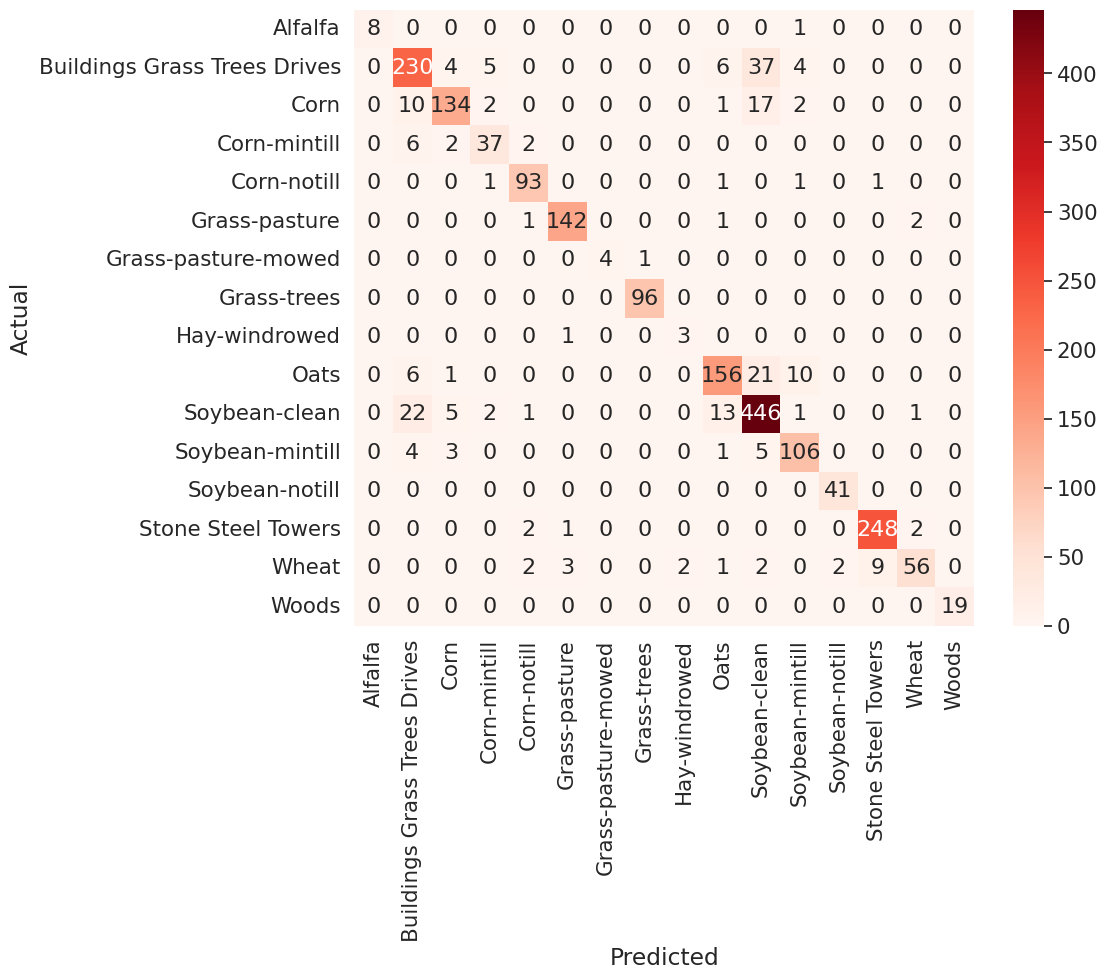

In [22]:
data = confusion_matrix(y_test, ypred)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)

In [23]:
print(classification_report(y_test, ypred, target_names = names))

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.89      0.94         9
                 Corn-notill       0.83      0.80      0.82       286
                Corn-mintill       0.90      0.81      0.85       166
                        Corn       0.79      0.79      0.79        47
               Grass-pasture       0.92      0.96      0.94        97
                 Grass-trees       0.97      0.97      0.97       146
         Grass-pasture-mowed       1.00      0.80      0.89         5
               Hay-windrowed       0.99      1.00      0.99        96
                        Oats       0.60      0.75      0.67         4
              Soybean-notill       0.87      0.80      0.83       194
             Soybean-mintill       0.84      0.91      0.88       491
               Soybean-clean       0.85      0.89      0.87       119
                       Wheat       0.95      1.00      0.98        41
                   